In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
import optuna
from optuna.samplers import TPESampler

In [2]:
dataset = pd.read_csv('../db/AmesHousing.csv', sep='\t')
localCopy=dataset.copy(deep=True)

In [3]:
#SEPARATION OF CATEGORICAL AND NUMERICAL FEATURES

#AmesExplanations.txt indicates a separation of the data in 4 types:
# Continuous - numerical
# Nominal - categorical
# Ordinal - usually categorical, numerical if order matters
# Discrete - usually numerical, categorical if it's an ID

cat_features = ['MS SubClass','MS Zoning','Street','Alley',
                'Lot Shape','Land Contour','Utilities','Lot Config',
                'Land Slope','Neighborhood','Condition 1','Condition 2',
                'Bldg Type','House Style','Roof Style','Roof Matl',
                'Exterior 1st','Exterior 2nd','Mas Vnr Type','Foundation',
                'Heating','Central Air','Electrical','Garage Type',
                'Paved Drive','Misc Feature','Sale Condition']

num_features = ['Lot Frontage','Lot Area','Overall Qual','Overall Cond',
                'Year Built','Year Remod/Add','Mas Vnr Area','Exter Qual',
                'Exter Cond','Bsmt Qual','Bsmt Cond','Bsmt Exposure',
                'BsmtFin Type 1', 'BsmtFin SF 1','BsmtFin Type 2','BsmtFin SF 2',
                'Bsmt Unf SF','Total Bsmt SF','Heating QC','1st Flr SF','2nd Flr SF',
                'Low Qual Fin SF','Gr Liv Area','Bsmt Full Bath','Bsmt Half Bath',
                'Full Bath','Half Bath','Bedroom','Kitchen','Kitchen Qual','TotRmsAbvGrd',
                'Functional','Fireplaces','Fireplace Qu',
                'Garage Yr Blt','Garage Finish','Garage Cars','Garage Area','Garage Qual',
                'Garage Cond','Wood Deck SF','Open Porch SF','Enclosed Porch','3-Ssn Porch',
                'Screen Porch','Pool Area','Pool QC','Fence','Misc Val','Mo Sold','Yr Sold',
                'Sale Type']


# Features that describe a grade (ex. Quality: 1-10 or Poor/Average/Excellent) will be treated as
# numeric values. There are string values as well; these will be mapped to numbers so that the model
# understands them

# to be mapped to numbers: Exter Qual, Exter Cond, Bsmt Qual, Bsmt Cond, Bsmt Exposure,
# BsmtFin Type 1, BsmtFinType 2, HeatingQC, KitchenQual, Functional, FireplaceQu, 
# Garage Finish, Garage Qual, Garage Cond, Pool QC, Fence, Sale Type

ordinal_maps = {'Exter Qual': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                'Exter Cond': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                'Bsmt Qual': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                'Bsmt Cond': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                'Bsmt Exposure': {'NA':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4},
                'BsmtFin Type 1': {'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
                'BsmtFin Type 2': {'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
                'Heating QC': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                'Kitchen Qual': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                'Functional': {'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':8},
                'Fireplace Qu': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                'Garage Finish': {'NA':0, 'Unf':1, 'RFn':2, 'Fin':3},
                'Garage Qual': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                'Garage Cond': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                'Pool QC': {'NA':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4},
                'Fence': {'NA':0, 'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4},
                'Sale Type': {'Oth':1, 'ConLD':2, 'ConLI':3, 'ConLw':4, 'Con':5, 'COD':6, 'New':7, 'VWD':8, 'CWD':9, 'WD':10}
                }

# apply the mappings to the strings
for col,mapping in ordinal_maps.items():
    if col in localCopy.columns:
        localCopy[col] = localCopy[col].map(mapping)

In [4]:
#FEATURE ENGINEERING: Deletion

#dropping the PID , Order Column
# Yr Sold, Sale Price, Year Built, Total Bsmt SF, Gr Liv Area because they have a high correlation with 
# other features, we are gonna keep them and delete the others
localCopy.drop(columns=['PID','Order','Overall Qual', 'Garage Yr Blt', '1st Flr SF','TotRms AbvGrd', 'Garage Cars'],inplace=True)
localCopy.drop(index=[1341,1497,1577,2236],inplace=True)

#dropping columns with many null values
for column in localCopy:
    if localCopy[column].isna().sum()>2000:
        localCopy.drop(column, axis=1, inplace=True)

#After all deletions, remove the deleted features in the 2 cat/num separation arrays as well
cat_features = [col for col in cat_features if col in localCopy.columns]
num_features = [col for col in num_features if col in localCopy.columns]
#Also do the same for the ordinal_maps
ordinal_maps = {col: mapping for col,mapping in ordinal_maps.items() if col in localCopy.columns}

In [5]:
#Separate the target variable from the rest
indexOfTV = localCopy.columns.get_loc("SalePrice")
X = localCopy.iloc[:,:indexOfTV]  #all rows and all columns except for the TV column
Y = localCopy.iloc[:,indexOfTV]  #column of the Target Variable with all the rows (":")

# compute the quartiles 
# step 1: copy/sort the data
Y_copy = Y.copy(deep=True).sort_values(ascending=True)
length = len(Y_copy)
# We define the 5 ranges: 25% | 16.7% | 16.7% | 16.7% | 25%
# First 25% is from min to 1st checkpoint, next 16.7% is from 1st to 2nd etc.
min = np.min(np.array(Y)); max = np.max(np.array(Y))
ranges = [min, -1, -1, -1, -1, max] 


Q2 = np.mean(np.array(Y_copy.iloc[(length//2)-1:length//2+1]))
cond = Y_copy <= Q2
half1, half2 = Y_copy[cond], Y_copy[~cond]

Q1 = np.median(np.array(half1))
Q3 = np.median(np.array(half2))

ranges[1] = Q1
ranges[4] = Q3

# Pentru rangeurile [25 | 16.7 | 16.7 | 16.7 | 25]
#                              p2     p3

p2 = int((length/4)+((length/2)/3))    
p3 = int((length/4)+((length/2)/3)*2) 

# valorile de pe pozitiile respective 
r2 = np.mean(np.array(Y_copy.iloc[(p2//2)-1:p2//2+1]))
r3 = np.mean(np.array(Y_copy.iloc[(p3//2)-1:p3//2+1]))

ranges[2] = r2
ranges[3] = r3

# change the target variable to a categorical format
classes = ["homeless type of shit", "cheap", "affordable", "expensive", "billionaire type of shit"]
cat_y: list[str] = []
for y in Y:
    if y <= ranges[1]:
        cat_y.append(classes[0])
    elif y <= ranges[2]:
        cat_y.append(classes[1])
    elif y <= ranges[3]:
        cat_y.append(classes[2])
    elif y <= ranges[4]:
        cat_y.append(classes[3])
    else:
        cat_y.append(classes[4])

Y = pd.Series(cat_y)

In [6]:
#FEATURE ENGINEERING: Scaling

#Scalam doar features numerice
scaler = MinMaxScaler()

scaled_data = X.copy(deep=True)
numericals = X.select_dtypes(include=['int64', 'float64']).columns

scaled_data[numericals] = scaler.fit_transform(X[numericals])

X = scaled_data

In [7]:
# One-Hot Encoding for the categorical variables
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

encodedData = encoder.fit_transform(X[cat_features])
encodedDataFrame = pd.DataFrame(encodedData, columns=encoder.get_feature_names_out(cat_features))

X = pd.concat([X, encodedDataFrame], axis=1)
X = X.drop(cat_features, axis=1)
X.drop(index=[1341,1497,1577,2236], axis=0, inplace=True)


# Ordinal Encoding for the hand-made classes of the target variable
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder(categories=[classes])

Y = encoder.fit_transform(pd.DataFrame(Y))
Y = pd.DataFrame(Y)

In [ ]:
# Optuna - Bayesian Optimisation

def objective(trial):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
    
    dtrain = xgb.DMatrix(X_train, label=Y_train)
    dvalid = xgb.DMatrix(X_test, label=Y_test)

    param = {
    "objective": "multi:softprob",  
    "eval_metric": "mlogloss",      
    "num_class": 5,                 
    "verbosity": 0,
    "subsample": trial.suggest_float("subsample", 0.4, 1.0),   
    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),   
    "min_child_weight": trial.suggest_float("min_child_weight", 1, 10),      
    }

    gbm = xgb.train(param, dtrain,
        num_boost_round=200,
        evals=[(dvalid, "validation")],
        early_stopping_rounds=20,
        verbose_eval=False,)

    preds = gbm.predict(dvalid)
    pred_labels = np.argmax(preds, axis=1)
    accuracy = accuracy_score(Y_test, pred_labels)
    return accuracy

study = optuna.create_study(direction="maximize", sampler=TPESampler(), pruner=optuna.pruners.MedianPruner(), study_name="Optune study object", load_if_exists=False)

study.enqueue_trial( { "subsample": 0.9, "colsample_bytree": 0.6, "min_child_weight": 2,} )
study.enqueue_trial( { "subsample": 0.75, "colsample_bytree": 0.8, "min_child_weight": 5,} )

study.optimize(objective, n_trials=100, timeout=600)


best_params = study.best_trial.params  
best_params.update({                  
    "objective": "multi:softprob",
    "num_class": 5,
    "eval_metric": "mlogloss"
})

Explained variance ratio:  [0.127 0.083 0.052 0.044 0.036 0.033 0.028 0.027 0.026 0.023]  ...
Cumulative variance:  [0.12736066 0.21009398 0.26193991 0.30551259 0.34159938]  ...

98% variance accumulated by 117 components
95% variance accumulated by 85 components
90% variance accumulated by 61 components
80% variance accumulated by 38 components


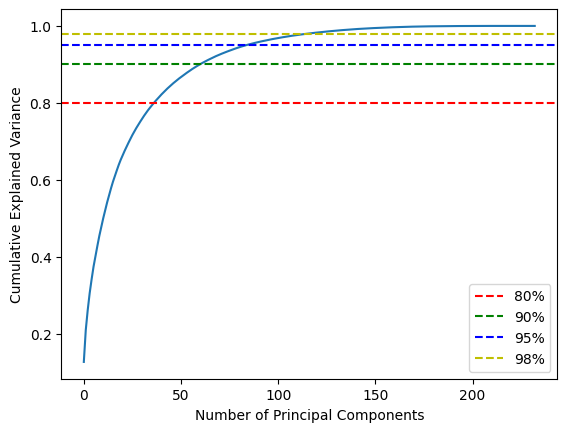

In [8]:
# LAB 4 --------------------------------
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# Pentru a folosi PCA, nu putem avea valori NaN
# Imputer doar face media aritmetica la feature si umple NaN-urile
imputer = SimpleImputer(strategy='mean')
X_filled = imputer.fit_transform(X)

# Run the PCA process
pca = PCA()  
X_pca = pca.fit_transform(X_filled)

# Explained variance = how much variance each PC covers
explained = pca.explained_variance_ratio_
explained_understandableValues = np.round(explained, 3)
print('Explained variance ratio: ', explained_understandableValues[:10], " ...")

# Cumulative sum: ex. for explained = [0.6, 0.25, 0.1, 0.05], cumulative = [PC1, PC1+PC2, PC1+PC2+PC3, ...] = [0.6, 0.85, 0.95, 1.0]
cumulative = np.cumsum(explained)
print('Cumulative variance: ',cumulative[:5], " ...\n")

# Vedem cate componente sunt incluse pentru fiecare dintre procentaje
for variance in [0.98, 0.95, 0.90, 0.80]:
    cnt = np.argmax(cumulative >= variance) + 1
    print(f"{variance*100:.0f}% variance accumulated by {cnt} components")

plt.plot(cumulative)
plt.axhline(y=0.8, color='r', linestyle='--', label='80%')
plt.axhline(y=0.9, color='g', linestyle='--', label='90%')
plt.axhline(y=0.95, color='b', linestyle='--', label='95%')
plt.axhline(y=0.98, color='y', linestyle='--', label='98%')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.legend()
plt.show()

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y, test_size=0.1, random_state=42)

dtrain = xgb.DMatrix(X_train, label=Y_train)
dtest = xgb.DMatrix(X_test)

model = xgb.train(best_params, dtrain, num_boost_round=100)

y_pred = model.predict(dtest)

y_pred = np.argmax(y_pred, axis=1)
print(f" Accuracy of prediction: {accuracy_score(Y_test, y_pred)}")

****************************
Initial-cluster model: random
Homogeneity: 0.176
Completeness: 0.154
Measuring: 0.164
Adjusted Random: 0.109
Adusted mutual info: 0.163
Silhouette: 0.082
****************************
Initial-cluster model: random
Homogeneity: 0.179
Completeness: 0.132
Measuring: 0.152
Adjusted Random: 0.093
Adusted mutual info: 0.150
Silhouette: 0.085


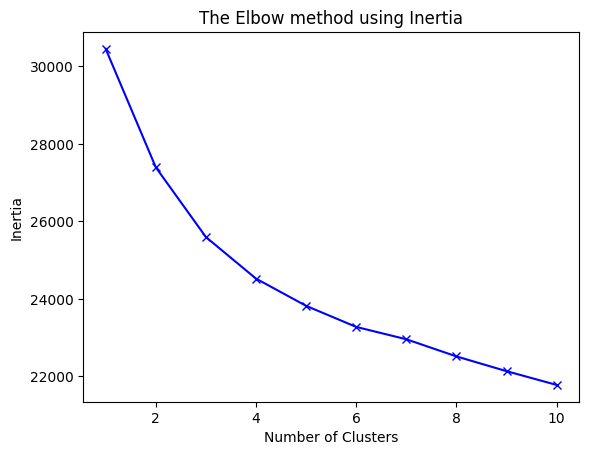

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
from scipy.spatial.distance import cdist

def benchmark(model: KMeans, name: str, data):

    model.fit(data)
    print(f"Initial-cluster model: {name}")
    Y_arr = Y.iloc[:, 0].to_numpy()
    # !!! DE MODIFICAT CU MASURATORI CORESPUNZATOARE
    # HOMOGENEITY
    print(f"Homogeneity: {homogeneity_score(Y_arr, model.labels_):.3f}")
    # COMPLETNESS SCORE
    print(f"Completeness: {completeness_score(Y_arr, model.labels_):.3f}")
    # V-Measuring
    print(f"Measuring: {v_measure_score(Y_arr, model.labels_):.3f}")
    # Adjusted Random
    print(f"Adjusted Random: {adjusted_rand_score(Y_arr, model.labels_):.3f}")
    # Adjusted mutual info
    print(f"Adusted mutual info: {adjusted_mutual_info_score(Y_arr, model.labels_):.3f}")
    # Silhouette
    print(f"Silhouette: {silhouette_score(X_pca, model.labels_):.3f}")
     

max_classes = 10
inertias = []

for no_classes in range(1, max_classes+1):
    kmeans_model = KMeans(init= "random", 
                          n_clusters=no_classes,
                          n_init=5, 
                          random_state=0)
    # within cluster sum of squares
    if no_classes == 5 or no_classes == 4:
        print("****************************")
        benchmark(kmeans_model, 'random', X_pca)
        inertias.append(kmeans_model.inertia_)
    else:
        kmeans_model.fit(X_pca)
        inertias.append(kmeans_model.inertia_)
# plotting the elbow method 
plt.plot(range(1, max_classes+1), inertias, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('The Elbow method using Inertia')
plt.show()

    


0.09672862548542623
0.08245258552864536
0.09036293731323995
0.08347685316874985


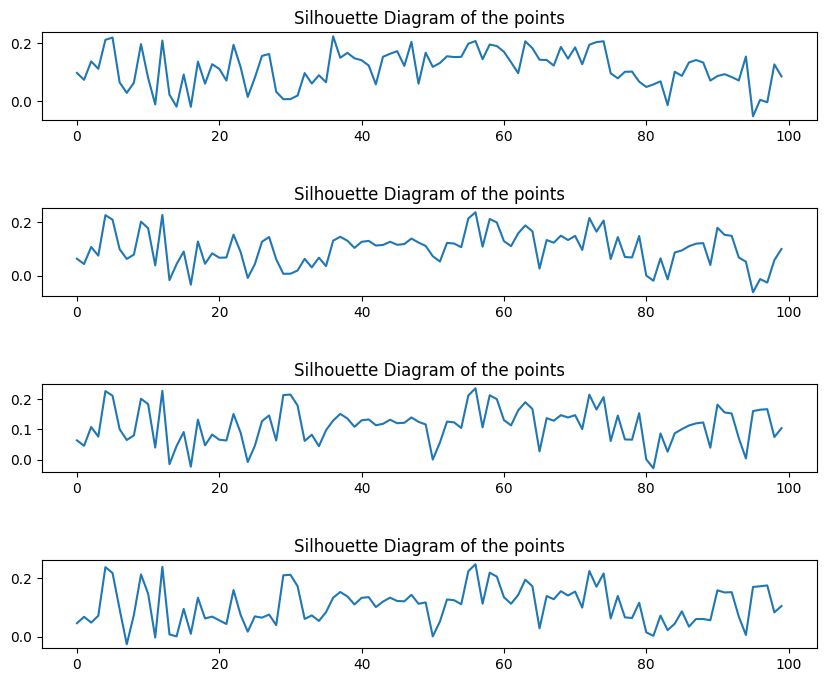

In [10]:
# Silhouette plotting 
from sklearn.metrics import silhouette_samples

fig, axis = plt.subplots(4, 1, figsize=(10, 8))
for k in range(3, 7):
    kmeans_model = KMeans(n_clusters=k, random_state=0)
    kmeans_model.fit(X_pca)
    data = silhouette_samples(X_pca, kmeans_model.labels_)
    avg_silhouette = silhouette_score(X_pca, kmeans_model.labels_)
    axis[k-3].plot(data[:100])
    axis[k-3].set_title('Silhouette Diagram of the points')
    print(avg_silhouette)
    
plt.subplots_adjust(wspace=0.4, hspace=1)
plt.show()

In [11]:
# PCA 
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler

for no_comp in range(100, 200, 5):
    # X_filled = StandardScaler().fit_transform(X_filled)
    pca = PCA(n_components=no_comp)
    X_pca = pca.fit_transform(X_filled)
    print(f"Variance Ratio: {pca.explained_variance_ratio_}")
    sum_variance = np.cumsum(pca.explained_variance_ratio_)
    comps = np.argmax(sum_variance > .98) + 1
    
    print(f"Number of PCA components necesarry for the reduction of the dataset's variance up to 98%: {comps}")




Variance Ratio: [0.12736066 0.08273331 0.05184593 0.04357267 0.0360868  0.03324415
 0.02789928 0.0266928  0.02588815 0.02329878 0.02222222 0.02090531
 0.02007939 0.018875   0.0177722  0.01701164 0.01515544 0.0146514
 0.01436604 0.01288812 0.01172446 0.01131781 0.01078674 0.01047813
 0.01027671 0.00973995 0.00915323 0.00878048 0.00836795 0.0079863
 0.00791245 0.0076432  0.00724283 0.00696365 0.00650251 0.00630644
 0.00613138 0.00579859 0.00564987 0.00555628 0.00543625 0.00510405
 0.00504196 0.00497633 0.00463336 0.00454025 0.00445787 0.00419265
 0.00415578 0.00402176 0.00381852 0.00380042 0.00371505 0.00359433
 0.00356136 0.00341779 0.00340386 0.00325323 0.00311168 0.00299557
 0.00294989 0.00284784 0.00272715 0.00263237 0.00255762 0.00248439
 0.00243365 0.00240843 0.0023834  0.00221936 0.00212121 0.00210441
 0.00204787 0.00198726 0.00191923 0.00190362 0.0018863  0.00183726
 0.00173901 0.00171895 0.00167807 0.00162809 0.0015256  0.00145635
 0.00141099 0.00136317 0.00130873 0.0012689  0.0

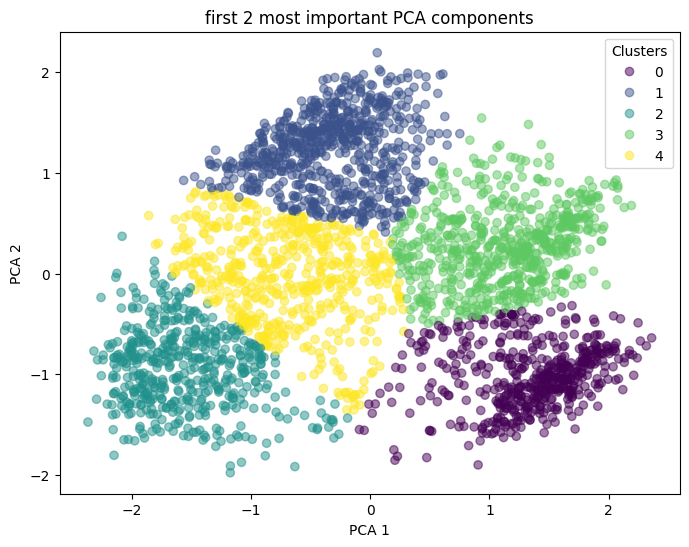

In [12]:
# plotting the first 2 imporant PCA components 

from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt 

# declare the PCA components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_filled)
# define the model
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(X_pca)

# plot the result
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=.5)
plt.legend(*scatter.legend_elements(), title='Clusters')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('first 2 most important PCA components')
plt.show()


# Based on the number of PCA components the number of clusters are affected 
# for example even if I increase the number of clusters because I end up projecting onto just 2 PCA the clusters 
# wont pass the number of 3 
# Also by adding too many PCA components the model is uncapable to separate it anymore into clusters 

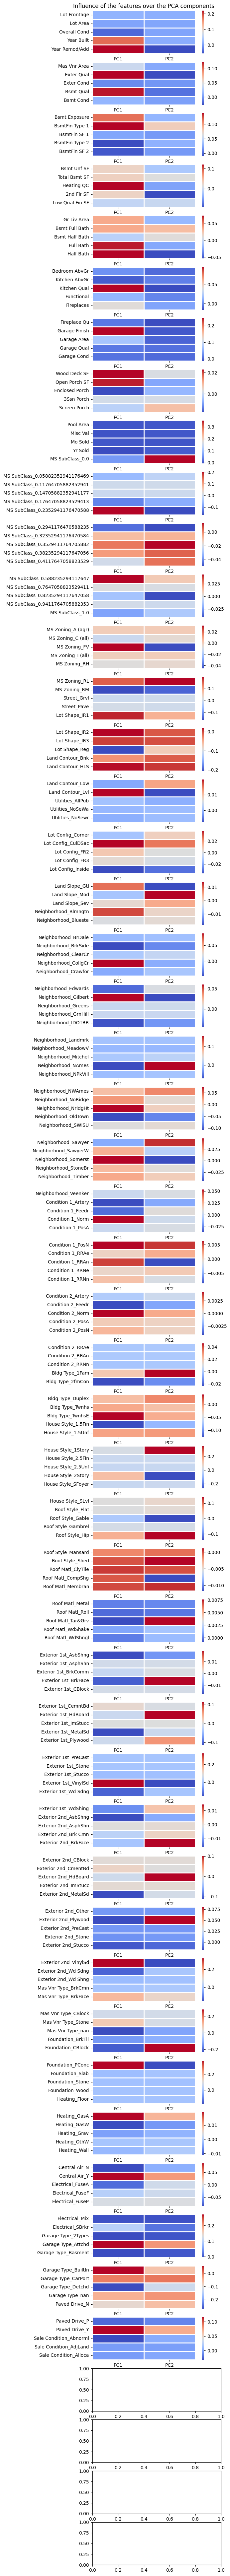

In [13]:
# influence of the features in the PCA components 
import pandas as pd
import seaborn as sns


loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
df = pd.DataFrame(loadings, index=X.columns, columns=['PC1',  'PC2'])

# plotting many heatmaps 
fig, axis = plt.subplots(nrows=50, ncols=1, figsize=(5, 100))
for j, i in enumerate(range(5, 231, 5)):
    sns.heatmap(df.iloc[i-5:i,], ax = axis[j%50], cmap='coolwarm', cbar=True, linewidths=1)
    
axis[0].set_title('Influence of the features over the PCA components')
plt.show()




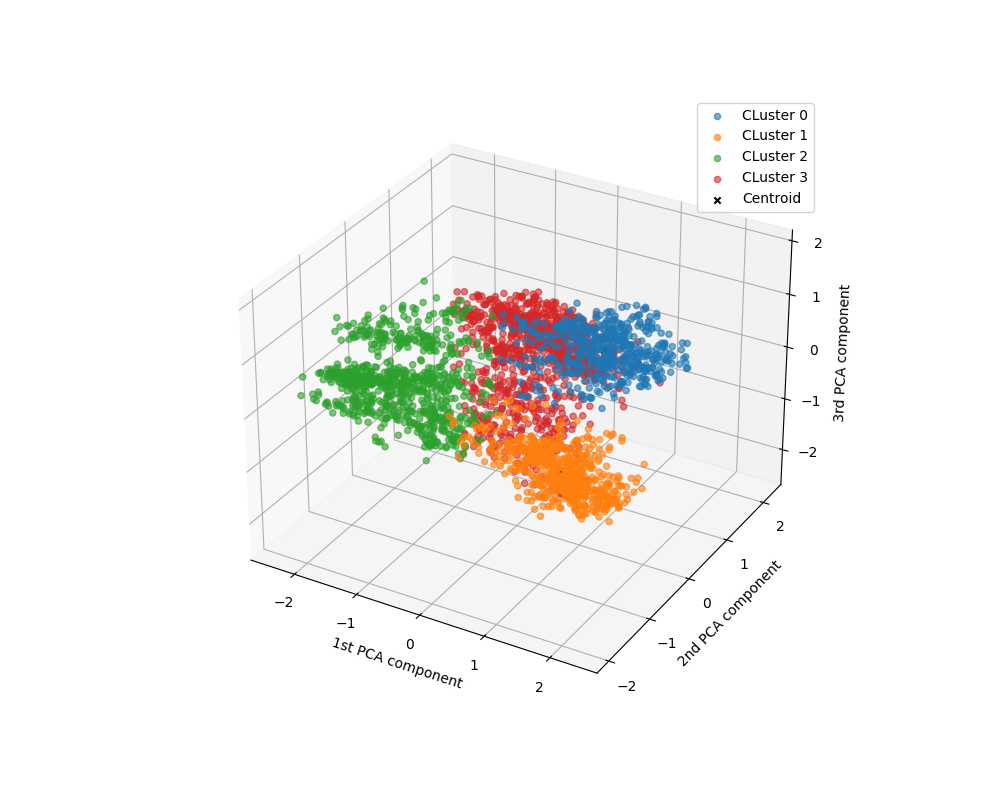

In [17]:
# 3D printing the 3 principal components and the clusteres 
# also make the centroids with another color 
# %matplotlib widget
%matplotlib widget

import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans

pca = PCA(n_components=3)
kmeans = KMeans(n_clusters=4, random_state=42)
X_pca = pca.fit_transform(X_filled)

labels = kmeans.fit_predict(X_pca)
centroids = kmeans.cluster_centers_



# plotting 
fig = plt.figure(figsize=(10, 8))
# axes = fig.add_subplot(111, projection='3d')
axes = fig.add_subplot(111, projection='3d')


for cluster in np.unique(labels):
    axes.scatter(X_pca[labels == cluster, 0],
                 X_pca[labels == cluster, 1], 
                 X_pca[labels == cluster, 2], 
                 label=f'CLuster {cluster}', alpha=.6)
    

axes.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='x',s=20, c='black', label='Centroid')

axes.set_xlabel('1st PCA component')
axes.set_ylabel('2nd PCA component')
axes.set_zlabel('3rd PCA component')
axes.legend()

plt.show()



